In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.linalg import expm, sqrtm

def Fidelity(rho_0, rho_1):
    '''
    calculate Fidelity of @rho_0 and @rho_1
    '''
    
    sqrt_rho_0 = sqrtm(rho_0)
    #sqrt_rho_0 = sp.linalg.sqrtm(rho_0)
    F = np.trace(sqrtm(sqrt_rho_0 @ rho_1 @ sqrt_rho_0))**2
    return F

In [2]:
zero = np.array([1., 0.])
one = np.array([0., 1.])

I = np.identity(2, dtype=np.complex64)
H = 1/np.sqrt(2)*np.array([[1, 1],
                           [1, -1]], dtype=np.complex64)
X = np.array([[0., 1.],
              [1., 0.]], dtype=np.complex64)
Z = np.array([[1., 0.],
              [0., -1.]], dtype=np.complex64)
S = np.array([[1., 0.],
              [0., 1j]], dtype=np.complex64)
P0 = np.array([[1., 0.],
              [0., 0.]], dtype=np.complex64)
P1 = np.array([[0., 0.],
              [0., 1.]], dtype=np.complex64)

def NKron(*args):
    '''
    return kroneker product of matrices
    '''
    result = np.array([[1.0]])
    for op in args:
        result = np.kron(result, op)
    return result

def ThreeQubitCoding(psi):
    psi00 = NKron(psi, zero, zero)[0]
    CNOT01 = NKron(P0, I, I) + NKron(P1, X, I)
    CNOT02 = NKron(P0, I, I) + NKron(P1, I, X)
    H3 = NKron(H, H, H)
    
    result = np.identity(2**3, dtype=np.complex64)
    result = H3 @ CNOT02 @ CNOT01
    
    return np.dot(result, psi00)

In [3]:
# кодирование состояния
psi = 1/np.sqrt(2)*np.array([1, np.exp(3*np.pi*1j/7)])
psi_L = ThreeQubitCoding(psi)
rho0 = np.outer(psi_L.conj(), psi_L)
#psi_L = np.dot(NKron(I, Z, I), psi_L)

In [112]:
def ErrorCorrection(state):
    
    H3 = NKron(H, H, H, I, I)
    CNOT03 = NKron(P0, I, I, I, I) + NKron(P1, I, I, X, I)
    CNOT14 = NKron(I, P0, I, I, I) + NKron(I, P1, I, I, X)
    CNOT13 = NKron(I, P0, I, I, I) + NKron(I, P1, I, X, I)
    CNOT24 = NKron(I, I, P0, I, I) + NKron(I, I, P1, I, X)
    
    U = H3 @ CNOT24 @ CNOT13 @ CNOT14 @ CNOT03 @ H3
    
    if state.ndim == 1:
        psi_L_with_ancilla_bit = NKron(state, zero, zero)[0]
        
        result = U @ psi_L_with_ancilla_bit
        return result
    
    elif state.ndim == 2:
        rho_with_ancilla_bit = NKron(state, P0, P0)
        
        result = U @ rho_with_ancilla_bit @ U.conj().T
        return result
    else:
        return None

def FixErrorZ(state_correction):
    # редуцируем состояние по вспомогательным кубитам
    if state_correction.ndim == 1:
        rho = np.outer(state_correction.conj(), state_correction)
    else: 
        rho = state_correction.copy()

    rho1 = np.trace(rho.reshape([16, 2, 16, 2]), axis1=1, axis2=3)
    rho_res = np.trace(rho1.reshape([8, 2, 8, 2]), axis1=1, axis2=3)
    
    # измерим синдром ошибки
    rho3 = np.trace(rho.reshape([16, 2, 16, 2]), axis1=0, axis2=2)
    rho4 = np.trace(rho1.reshape([8, 2, 8, 2]), axis1=0, axis2=2)
    
    state1 = np.round(rho3[1,1].real)
    state2 = np.round(rho4[1,1].real)
    #print("state1: ", rho3)
    #print("state2", rho4)
    
    if np.isclose(state1, 1) and np.isclose(state2, 0):
        Z3 = NKron(I, I, Z)
        result = Z3 @ rho_res @ Z3.conj().T
        
        return result
    
    elif np.isclose(state1, 0) and np.isclose(state2, 1):
        Z1 = NKron(Z, I, I)
        result = Z1 @ rho_res @ Z1.conj().T
        # print("Z1")
        
        return result
    
    elif np.isclose(state1, 1) and np.isclose(state2, 1):
        Z2 = NKron(I, Z, I)
        result = Z2 @ rho_res @ Z2.conj().T
        
        return result
    else:
        
        return rho_res

Для начала проверим, что корреекция ошибок не меняет исходное состояние без ошибок

In [113]:
psi_correction = ErrorCorrection(psi_L)
rho_ideal = FixErrorZ(psi_correction)

In [114]:
Fidelity(rho0, rho_ideal)

(0.9999996094016819-7.3939484094884134e-09j)

#### Пункт 4

In [115]:
Z1 = NKron(Z, I, I)
psi_error1 = Z1 @ psi_L

psi_correction = ErrorCorrection(psi_error1)
rho1 = FixErrorZ(psi_correction)
fid1 = np.abs(Fidelity(rho0, rho1))

Z2 = NKron(I, Z, I)
psi_error2 = Z2 @ psi_L

psi_correction = ErrorCorrection(psi_error2)
rho2 = FixErrorZ(psi_correction)
fid2 = np.abs(Fidelity(rho0, rho2))

Z3 = NKron(I, I, Z)
psi_error3 = Z3 @ psi_L

psi_correction = ErrorCorrection(psi_error3)
rho3 = FixErrorZ(psi_correction)
fid3 = np.abs(Fidelity(rho0, rho3))

print("Ошибка в первом кубите {:.3f}".format(fid1))
print("Ошибка во втором кубите {:.3f}".format(fid2))
print("Ошибка в третьем кубите {:.3f}".format(fid3))

Ошибка в первом кубите 1.000
Ошибка во втором кубите 1.000
Ошибка в третьем кубите 1.000


#### Пункт№5

In [142]:
def Craus(rho_in, E):
    rho_out = np.zeros_like(rho_in)
    
    for j in range(len(E)):
        rho_out += E[j] @ rho_in @ E[j].T.conj()
            
    return rho_out

def Craus_3qubit(rho_in, E):
    rho_out = np.zeros_like(rho_in)
    rho_out1 = np.zeros_like(rho_in)
    rho_out2 = np.zeros_like(rho_in)
    
    for j in range(len(E)):
        rho_out += NKron(E[j], I, I) @ rho_in @ NKron(E[j], I, I).T.conj()
        
    for j in range(len(E)):
        rho_out1 += NKron(I, E[j], I) @ rho_out @ NKron(I, E[j], I).T.conj()
        
    for j in range(len(E)):
        rho_out2 += NKron(I, I, E[j]) @ rho_out1 @ NKron(I, I, E[j]).T.conj()
    
    #rho_out /= rho_out.trace()
    return rho_out2

E1 = lambda p: np.sqrt(0.8*p)*Z
E2 = lambda p: np.sqrt(0.2*p)*S 
# E2 = lambda p: 0*I
E0 = lambda p: np.sqrt(1-p)*I 

In [143]:
p_max = 0.9
p_arr = np.linspace(0, p_max, 100)
fid_arr_with_corr = np.zeros_like(p_arr)
fid_arr_no_corr = np.zeros_like(p_arr)

for i in range(len(p_arr)):
    # с кодом коррекции
    p = p_arr[i]
    # E = [NKron(E0(p), E0(p), E0(p)), NKron(E1(p), E1(p), E1(p)), NKron(E2(p), E2(p), E2(p))]
    # rho_error = Craus(rho0, E)
    E = [E0(p), E1(p), E2(p)]
    rho_error = Craus_3qubit(rho0, E)
    rho_correction = ErrorCorrection(rho_error)
    rho_res = FixErrorZ(rho_correction)
    
    # print(rho_res.trace())

    fid_arr_with_corr[i] = np.abs(Fidelity(rho0, rho_res))
    
    # без кода коррекции
    E_ = [E0(p), E1(p), E2(p)]
    rho_one_qubit = np.outer(psi.conj(), psi)
    rho_error = Craus(rho_one_qubit, E_)
    fid_arr_no_corr[i] = np.abs(Fidelity(rho_one_qubit, rho_error))
    
    # fid_arr_no_corr[i] = np.abs(Fidelity(rho0, rho_error))

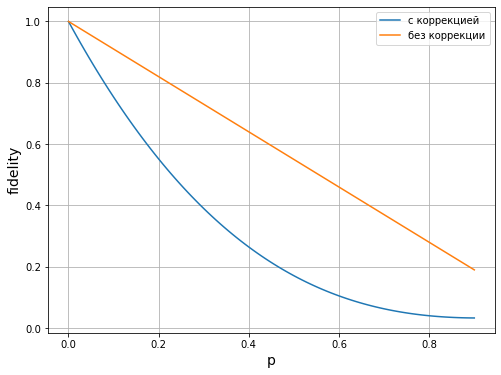

In [144]:
plt.figure(figsize=(8,6))

plt.plot(p_arr, fid_arr_with_corr, label='с коррекцией')
plt.plot(p_arr, fid_arr_no_corr, label='без коррекции')

plt.xlabel("p", fontsize=14)
plt.ylabel("fidelity", fontsize=14)

plt.legend()
plt.grid(True)

In [77]:
def printMatrix(A):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            print("{:.3f}| ".format(A[i][j]), end=''),
        print("\n")

In [79]:
# кодирование состояния
psi = 1/np.sqrt(2)*np.array([1, np.exp(3*np.pi*1j/7)])
psi_L = ThreeQubitCoding(psi)
rho0 = np.outer(psi_L.conj(), psi_L)

printMatrix(rho0)

0.153+0.000j| -0.000-0.122j| -0.000-0.122j| 0.153+0.000j| -0.000-0.122j| 0.153+0.000j| 0.153+0.000j| -0.000-0.122j| 

-0.000+0.122j| 0.097+0.000j| 0.097+0.000j| -0.000+0.122j| 0.097+0.000j| -0.000+0.122j| -0.000+0.122j| 0.097+0.000j| 

-0.000+0.122j| 0.097+0.000j| 0.097+0.000j| -0.000+0.122j| 0.097+0.000j| -0.000+0.122j| -0.000+0.122j| 0.097+0.000j| 

0.153+0.000j| -0.000-0.122j| -0.000-0.122j| 0.153+0.000j| -0.000-0.122j| 0.153+0.000j| 0.153+0.000j| -0.000-0.122j| 

-0.000+0.122j| 0.097+0.000j| 0.097+0.000j| -0.000+0.122j| 0.097+0.000j| -0.000+0.122j| -0.000+0.122j| 0.097+0.000j| 

0.153+0.000j| -0.000-0.122j| -0.000-0.122j| 0.153+0.000j| -0.000-0.122j| 0.153+0.000j| 0.153+0.000j| -0.000-0.122j| 

0.153+0.000j| -0.000-0.122j| -0.000-0.122j| 0.153+0.000j| -0.000-0.122j| 0.153+0.000j| 0.153+0.000j| -0.000-0.122j| 

-0.000+0.122j| 0.097+0.000j| 0.097+0.000j| -0.000+0.122j| 0.097+0.000j| -0.000+0.122j| -0.000+0.122j| 0.097+0.000j| 



In [109]:
p = 0.5
E = [E0(p), E1(p)]

rho_error = Craus_3qubit(rho0, E)
print("Сравнение состояния и ошибкой и без\n", np.isclose(rho0, rho_error))
printMatrix(rho_error)
rho_correction = ErrorCorrection(rho_error)
rho_res = FixErrorZ(rho_correction)
print("После коррекции:")
printMatrix(rho_res)

Сравнение состояния и ошибкой и без
 [[ True  True  True  True False False False False]
 [ True  True  True  True False False False False]
 [ True  True  True  True False False False False]
 [ True  True  True  True False False False False]
 [False False False False  True  True  True  True]
 [False False False False  True  True  True  True]
 [False False False False  True  True  True  True]
 [False False False False  True  True  True  True]]
0.153+0.000j| -0.000-0.122j| -0.000-0.122j| 0.153+0.000j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 

-0.000+0.122j| 0.097+0.000j| 0.097+0.000j| -0.000+0.122j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 

-0.000+0.122j| 0.097+0.000j| 0.097+0.000j| -0.000+0.122j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 

0.153+0.000j| -0.000-0.122j| -0.000-0.122j| 0.153+0.000j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 

0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 0.000+0.000j| 0.097+0.000j| -0.000+0.122j| -0.00

#### проверим, через чистое состояние

In [102]:
psi_error1 = Z2 @ psi_L
rho_error1 = np.outer(psi_error1.conj(), psi_error1)
printMatrix(rho_error1)

0.153+0.000j| -0.000-0.122j| 0.000+0.122j| -0.153+0.000j| -0.000-0.122j| 0.153+0.000j| -0.153+0.000j| 0.000+0.122j| 

-0.000+0.122j| 0.097+0.000j| -0.097+0.000j| 0.000-0.122j| 0.097+0.000j| -0.000+0.122j| 0.000-0.122j| -0.097+0.000j| 

0.000-0.122j| -0.097+0.000j| 0.097+0.000j| -0.000+0.122j| -0.097+0.000j| 0.000-0.122j| -0.000+0.122j| 0.097+0.000j| 

-0.153+0.000j| 0.000+0.122j| -0.000-0.122j| 0.153+0.000j| 0.000+0.122j| -0.153+0.000j| 0.153+0.000j| -0.000-0.122j| 

-0.000+0.122j| 0.097+0.000j| -0.097+0.000j| 0.000-0.122j| 0.097+0.000j| -0.000+0.122j| 0.000-0.122j| -0.097+0.000j| 

0.153+0.000j| -0.000-0.122j| 0.000+0.122j| -0.153+0.000j| -0.000-0.122j| 0.153+0.000j| -0.153+0.000j| 0.000+0.122j| 

-0.153+0.000j| 0.000+0.122j| -0.000-0.122j| 0.153+0.000j| 0.000+0.122j| -0.153+0.000j| 0.153+0.000j| -0.000-0.122j| 

0.000-0.122j| -0.097+0.000j| 0.097+0.000j| -0.000+0.122j| -0.097+0.000j| 0.000-0.122j| -0.000+0.122j| 0.097+0.000j| 



In [106]:
A =  NKron(I, I, I) @ rho0 @ NKron(I, I, I).T.conj()*0.5 + NKron(I, Z, I) @ rho0 @ NKron(I, Z, I).T.conj()*0.5

rho_correction = ErrorCorrection(rho_error)
rho_res = FixErrorZ(rho_correction)

printMatrix(A)
A.trace()

0.153+0.000j| -0.000-0.122j| 0.000+0.000j| 0.000+0.000j| -0.000-0.122j| 0.153+0.000j| 0.000+0.000j| 0.000+0.000j| 

-0.000+0.122j| 0.097+0.000j| 0.000+0.000j| 0.000+0.000j| 0.097+0.000j| -0.000+0.122j| 0.000+0.000j| 0.000+0.000j| 

0.000+0.000j| 0.000+0.000j| 0.097+0.000j| -0.000+0.122j| 0.000+0.000j| 0.000+0.000j| -0.000+0.122j| 0.097+0.000j| 

0.000+0.000j| 0.000+0.000j| -0.000-0.122j| 0.153+0.000j| 0.000+0.000j| 0.000+0.000j| 0.153+0.000j| -0.000-0.122j| 

-0.000+0.122j| 0.097+0.000j| 0.000+0.000j| 0.000+0.000j| 0.097+0.000j| -0.000+0.122j| 0.000+0.000j| 0.000+0.000j| 

0.153+0.000j| -0.000-0.122j| 0.000+0.000j| 0.000+0.000j| -0.000-0.122j| 0.153+0.000j| 0.000+0.000j| 0.000+0.000j| 

0.000+0.000j| 0.000+0.000j| -0.000-0.122j| 0.153+0.000j| 0.000+0.000j| 0.000+0.000j| 0.153+0.000j| -0.000-0.122j| 

0.000+0.000j| 0.000+0.000j| 0.097+0.000j| -0.000+0.122j| 0.000+0.000j| 0.000+0.000j| -0.000+0.122j| 0.097+0.000j| 



(0.9999998973143779+0j)

In [43]:
rho0 = np.outer(psi_L.conj(), psi_L)
rho = NKron(rho0, P0, P1)
rho.shape

(32, 32)

In [252]:
np.outer(psi, psi)

array([[ 0.5       +0.j        ,  0.11126047+0.48746396j],
       [ 0.11126047+0.48746396j, -0.45048443+0.21694187j]])

In [253]:
rho1 = np.trace(rho.reshape([16, 2, 16, 2]), axis1=1, axis2=3)
rho2 = np.trace(rho1.reshape([8, 2, 8, 2]), axis1=1, axis2=3)

In [254]:
Fidelity(rho2, rho0)

(0.9999998011325909+5.2637960620522866e-09j)

In [255]:
rho3 = np.trace(rho.reshape([16, 2, 16, 2]), axis1=0, axis2=2)
#rho3/=np.trace(rho3)
np.round(rho3, 6)

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [256]:
rho4 = np.trace(rho1.reshape([8, 2, 8, 2]), axis1=0, axis2=2)
#rho4/=np.trace(rho4)
np.round(rho4, 6)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [257]:
rho1_ = np.trace(rho.reshape([8, 4, 8, 4]), axis1=0, axis2=2)
np.trace(rho1_.reshape([2, 2, 2, 2]), axis1=0, axis2=2)

array([[0.       +0.j, 0.       +0.j],
       [0.       +0.j, 0.9999999+0.j]])

In [200]:
np.isclose(rho4[0,0], 0)

False

In [203]:
rho4[0,0]

(9.026337517069773e-34+0j)